## Data 512A Project Part1 - Common Analysis

This part of project focused only on the Honolulu, Hwaii Data and completed the following tasks:
- Data acquisition and Data cleaning
- Analysis on the common research question "How did masking policies change the progression of confirmed COVID-19 cases from February 1, 2020 through October 1, 2021?"
- Create visulizations

In [1]:
# import all required packages
from matplotlib import dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

#### Step 1: Data acquisition and Data Cleaning

- extract general information and cases by date for Honolulu, Hawaii Data
- calculat daily infect rate and derivative function of daily infection rate
- re-label and fill missing value for Face Masks Requirement data

In [2]:
#read in all the csv files
raw_us_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mask_mandates = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

In [3]:
# Focus only on Honolulu, Hwaii Data
raw_Honolulu_cases = raw_us_cases[(raw_us_cases["Province_State"] == "Hawaii") & (raw_us_cases["Admin2"] == "Honolulu")]
# Save general information as DataFrame, first 12 columns
Honolulu_info = raw_Honolulu_cases[raw_Honolulu_cases.columns[0:11]]
# Save cases by Date Data as DataFrame
Honolulu_cases_by_date = raw_Honolulu_cases[raw_Honolulu_cases.columns[11:]]
# Pivot the DataFrame for better readinng
Honolulu_cases_by_date = pd.DataFrame(Honolulu_cases_by_date.iloc[0])
Honolulu_cases_by_date = Honolulu_cases_by_date.reset_index()
# rename the columns
Honolulu_cases_by_date.columns = ["Date", "Cases"]
# since the mask policy data only contains observation from 2020-4-10 to 2021-08-15
# subset the data to match the mask policy data
Honolulu_cases_by_date_subset = Honolulu_cases_by_date.loc[79:571,]
Honolulu_cases_by_date_subset = Honolulu_cases_by_date_subset.reset_index(drop=True)
# Calculate infect rate by taking the first derivative of cases data
Honolulu_cases_by_date_subset["Infect_rate"] = pd.Series(np.gradient(Honolulu_cases_by_date_subset['Cases']), Honolulu_cases_by_date_subset["Date"], name='Infect_rate').values
# Calculate Derivative function of infection rate data
Honolulu_cases_by_date_subset["Derivative_function"] = pd.Series(np.gradient(Honolulu_cases_by_date_subset["Infect_rate"]), Honolulu_cases_by_date_subset["Date"], name='Derivative_functions').values
# convert date to pandas datetime
Honolulu_cases_by_date_subset["Date"] = pd.to_datetime(Honolulu_cases_by_date_subset["Date"])
Honolulu_cases_by_date_subset

,Date,Cases,Infect_rate,Derivative_function
0,2020-04-10,334,9.0,-1.00
1,2020-04-11,343,8.0,-2.25
2,2020-04-12,350,4.5,-2.00
3,2020-04-13,352,4.0,2.00
4,2020-04-14,358,8.5,0.75
...,...,...,...,...
488,2021-08-11,34291,299.5,137.00
489,2021-08-12,34592,569.0,195.50
490,2021-08-13,35429,690.5,-12.75
491,2021-08-14,35973,543.5,-73.75


In [4]:
# Focus only on Honolulu, Hwaii Data
Honolulu_FIPS = Honolulu_info["FIPS"].values[0]
Honolulu_mask_use =  mask_use_by_county[mask_use_by_county["COUNTYFP"] == Honolulu_FIPS]
Honolulu_mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
547,15003,0.011,0.012,0.027,0.151,0.798


In [5]:
# Focus only on Honolulu, Hwaii Data
Honolulu_mask_mandates = mask_mandates[(mask_mandates["State_Tribe_Territory"] == "HI")  & (mask_mandates['County_Name'] == 'Hawaii County')]
Honolulu_mask_mandates_clean = Honolulu_mask_mandates.copy()
# fill missing value
Honolulu_mask_mandates_clean["Face_Masks_Required_in_Public"] = Honolulu_mask_mandates["Face_Masks_Required_in_Public"].fillna("No")
Honolulu_mask_mandates_clean = Honolulu_mask_mandates_clean.loc[:,['date','Face_Masks_Required_in_Public']]
# reset index
Honolulu_mask_mandates_clean = Honolulu_mask_mandates_clean.reset_index(drop=True)
# change date to pandas datetime format
Honolulu_mask_mandates_clean["date"] = pd.to_datetime(Honolulu_mask_mandates_clean["date"])
Honolulu_mask_mandates_clean

,date,Face_Masks_Required_in_Public
0,2020-04-10,No
1,2020-04-11,No
2,2020-04-12,No
3,2020-04-13,No
4,2020-04-14,No
...,...,...
488,2021-08-11,Yes
489,2021-08-12,Yes
490,2021-08-13,Yes
491,2021-08-14,Yes


#### Step 2: Analyze

- find mask requirement policy change date
- with help of python ruptures package find the statistically significant change points for rate of infection
- find the statistically significant change points for the derivative function of rate of infection

##### Finding: The mask policy only changed once at Honolulu, Hawaii; the index is 7 --- date is 2020-4-17

In [6]:
# find date that the mask requiremnt is different than the next day
mask_change_list = (Honolulu_mask_mandates_clean['Face_Masks_Required_in_Public'] != Honolulu_mask_mandates_clean['Face_Masks_Required_in_Public'].shift(1)).to_list()
# keep all policy change day in a list
mask_policy_change_location = np.where(mask_change_list)[0].tolist()
mask_policy_change_location.pop(0)
mask_policy_change_location

[7]

##### Finding: There are four statistically significant change points for the infect rate time series data:
- 2020-07-29
- 2020-09-07
- 2021-01-30
- 2021-07-14

In [7]:
import ruptures as rpt
rate_of_infection = np.array(Honolulu_cases_by_date_subset["Infect_rate"])
algo1 = rpt.Pelt(model="rbf").fit(rate_of_infection)
rate_change_location = algo1.predict(pen=10)
rate_change_location = Honolulu_cases_by_date_subset["Date"][rate_change_location[:-1]]
rate_change_location

110   2020-07-29
150   2020-09-07
295   2021-01-30
460   2021-07-14
Name: Date, dtype: datetime64[ns]

##### Finding: There is only one statistically significant change point for the derivative function of infect rate time series data:
- 2020-07-29

In [8]:
derivative_function = np.array(Honolulu_cases_by_date_subset["Derivative_function"])
algo2 = rpt.Pelt(model="rbf").fit(derivative_function)
derivative_function_change_location = algo2.predict(pen=10)
derivative_function_change_location = Honolulu_cases_by_date_subset["Date"][derivative_function_change_location[:-1]]
derivative_function_change_location

100   2020-07-19
Name: Date, dtype: datetime64[ns]

##### General Findings:

Based on the analysis, it can be find that before 2020-4-17 Honolulu does not require masks in public; since then masks are required unntil august 15, 2021.

Since for most (except the first week) days in this time period there is a masking policy, and around 80% population in Honolulu always wearing a mask, it is difficult to evaluate how masking policies change the progression of confirmed COVID-19 cases in Honolulu. 

However, since Honolulu holds a strict maskinng policy, it would be interesting if we can find another county which holds a relatively loose policy for masking. By comparing the rate of changes of the two county, we might be able to answer how masking policies change the progression of confirmed COVID-19 cases in general.

#### Step 3: visualization
- Honolulu (Hwaii) Rate of Daily Infections from April 2020 to August 2021
- Honolulu (Hwaii) Derivative Function of Rate of Infections from April 2020 to August 2021

In [9]:
# convert yes/no to 0/1 for plot
Honolulu_mask_mandates_clean["Face_Masks_Required_in_Public"] = Honolulu_mask_mandates_clean["Face_Masks_Required_in_Public"].eq('Yes').mul(1)

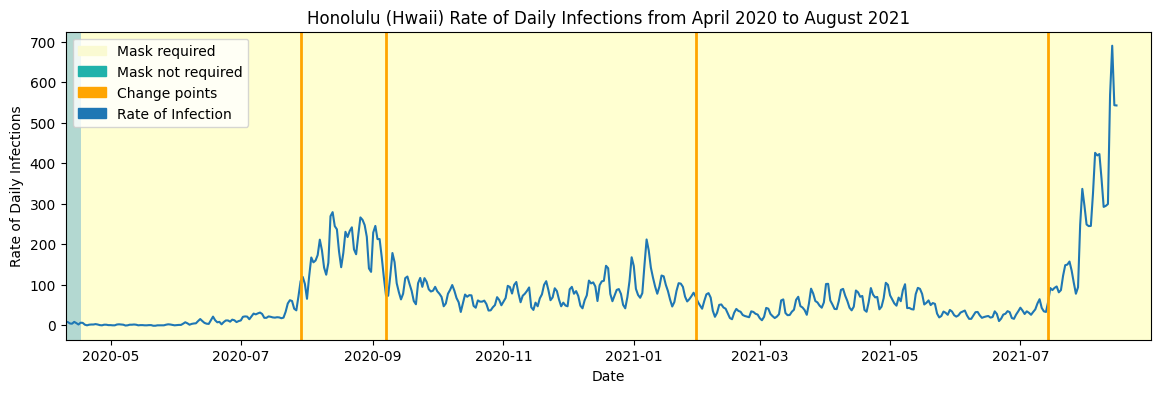

In [10]:
# Honolulu (Hwaii) Rate of Daily Infections from April 2020 to August 2021
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot()
ax.plot(Honolulu_cases_by_date_subset["Date"], Honolulu_cases_by_date_subset["Infect_rate"],label="Rate of Infection")
ax.set_xlim([datetime.date(2020, 4, 10), datetime.date(2021, 8, 31)])

# change background color based on mask requirement policy
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              Honolulu_mask_mandates_clean["Face_Masks_Required_in_Public"].values[np.newaxis],
              cmap='summer', alpha=0.3)

# plot significant change point
for i in rate_change_location:
    plt.axvline(i, lw=2, color='orange')

# add legend
import matplotlib.patches as mpatches
yellow_patch = mpatches.Patch(color='lightgoldenrodyellow', label='Mask required')
green_patch = mpatches.Patch(color='lightseagreen', label='Mask not required')
orange_patch = mpatches.Patch(color='orange', label='Change points')
blue_patch = mpatches.Patch(color='#1f77b4', label='Rate of Infection')

# add label, title
ax.set_xlabel('Date')
ax.set_ylabel('Rate of Daily Infections')
ax.set_title('Honolulu (Hwaii) Rate of Daily Infections from April 2020 to August 2021')
ax.legend(handles=[yellow_patch, green_patch, orange_patch, blue_patch])

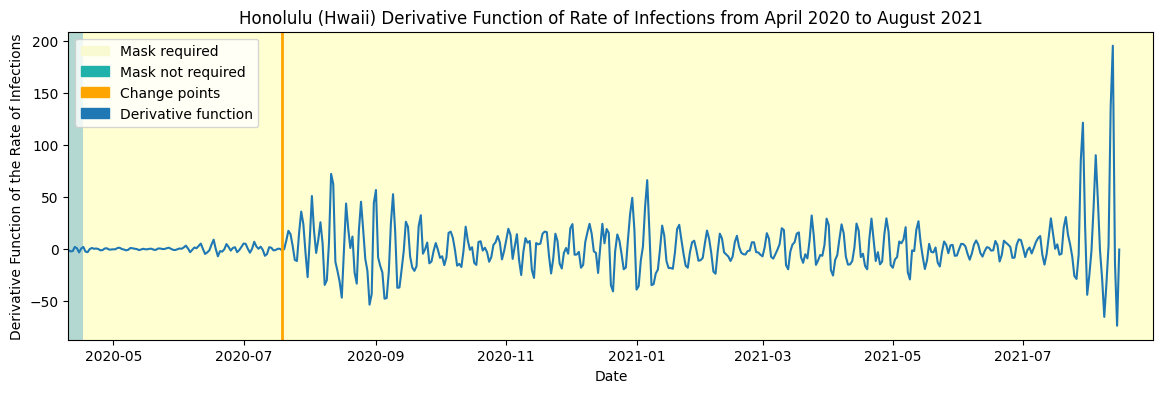

In [11]:
# Honolulu (Hwaii) Derivative Function of Rate of Infections from April 2020 to August 2021
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot()
ax.plot(Honolulu_cases_by_date_subset["Date"], Honolulu_cases_by_date_subset["Derivative_function"])
ax.set_xlim([datetime.date(2020, 4, 10), datetime.date(2021, 8, 31)])

# change background color based on mask requirement policy
ax.pcolorfast(ax.get_xlim(), ax.get_ylim(),
              Honolulu_mask_mandates_clean["Face_Masks_Required_in_Public"].values[np.newaxis],
              cmap='summer', alpha=0.3)

# plot significant change point
for i in derivative_function_change_location:
    plt.axvline(i, lw=2, color='orange')

# add legend
yellow_patch = mpatches.Patch(color='lightgoldenrodyellow', label='Mask required')
green_patch = mpatches.Patch(color='lightseagreen', label='Mask not required')
orange_patch = mpatches.Patch(color='orange', label='Change points')
blue_patch = mpatches.Patch(color='#1f77b4', label='Derivative function')

# add label, title
ax.set_xlabel('Date')
ax.set_ylabel('Derivative Function of the Rate of Infections')
ax.set_title('Honolulu (Hwaii) Derivative Function of Rate of Infections from April 2020 to August 2021')
ax.legend(handles=[yellow_patch, green_patch, orange_patch, blue_patch])